In [79]:
using Revise

In [2]:
using UnPack

In [3]:
using ImmersedLayers

In [83]:
using HeatForecastAnyShape

In [5]:
using CairoMakie

In [6]:
using LaTeXStrings

In [7]:
using Distributions
using Random
using LinearAlgebra
using GaussianMixtures
using Statistics

In [8]:
using JLD2

### True data

In [18]:
δ_true = 0.01
zq = [0.5+1.2im]
qq = [1.0]
c1q = [0.5]
c2q = [0.25]
Nq_true = length(zq)

1

### Set some plotting themes

In [19]:
xytheme = Theme(
        Axis = (aspect=DataAspect(),xlabel=L"x",ylabel=L"y"),
        palette = (color = Makie.wong_colors(),),
        Lines = (cycle = [:color],),
        Scatter = (cycle = [:color],)
    );

sensortheme = Theme(
    Axis = (xlabel="Sensor no.",ylabel=L"T-T_{ref}") # xticks=1:length(sens),
);

### Set up the observer for the true data

In [20]:
config_true, x_true = get_config_and_state(zq,qq,c1q,c2q)
ϵmeas_data = [1e-5,1e-4,2.5e-4,3.75e-4,5e-4,6.25e-4,8e-4,1e-3,1.5e-3,2e-3,3e-3,4e-3];
x_true

5-element Vector{Float64}:
 0.5
 1.2
 1.0
 0.5
 0.25

### Heater Estimation

In [21]:
Nq_estimator = 1
δ = 0.01
config_estimator = HeaterConfig(Nq_estimator)


# ranges to confine the prior mean to
xr = (-2.0,2.0)
yr = (0.01,2) #(0.01,4) #(0.01,2.0)
qr = (-2,2)
c1r = (0,1)
c2r = (0,1)
bounds = create_state_bounds(xr,yr,qr,c1r,c2r,config_estimator);
bounds

5-element Vector{Tuple{Float64, Float64}}:
 (-2.0, 2.0)
 (0.01, 2.0)
 (-2.0, 2.0)
 (0.0, 1.0)
 (0.0, 1.0)

In [22]:
#bounds for numerical domain
xr = (-2.0,2.0)
yr = (-2.0,2.0) #(0.01,4) #(0.01,2.0)
qr = (-2,2)
c1r = (0,1)
c2r = (0,1)
bounds_num = create_state_bounds(xr,yr,qr,c1r,c2r,config_estimator);
bounds_num

5-element Vector{Tuple{Float64, Float64}}:
 (-2.0, 2.0)
 (-2.0, 2.0)
 (-2.0, 2.0)
 (0.0, 1.0)
 (0.0, 1.0)

### Set up the MCMC parameters

In [23]:
## Parallel tempering ##
propvarX_coarse = 0.01^2 
propvarY_coarse = 0.01^2
propvarQ_coarse = 0.05^2 #0.05^2
propvarC_coarse = 0.01^2

propvarX_fine = 0.005^2 # 0.01^2
propvarY_fine = 0.005^2 # 0.01^2
propvarQ_fine = 0.01^2 # 0.005^2 # 0.01^2
propvarC_fine = 0.005^2

#Ntrial = [10000, 600000]
#propvar = [state_covariance(propvarX_coarse,propvarY_coarse,propvarQ_coarse,propvarR_coarse,config_estimator),
           #state_covariance(propvarX_fine,propvarY_fine,propvarQ_fine,propvarR_fine,config_estimator)];
Ntrial = [10000]
propvar = [state_covariance(propvarX_coarse,propvarY_coarse,propvarQ_coarse,propvarC_coarse,config_estimator)];

### Getting results for a specific case

In [24]:
Δx = 0.01
Ntheta = 500
gridConfig = constructGrids(Δx,bounds_num;Ntheta)

constructGrids{Tuple{Float64, Float64}, BasicILMCache{0, GridScaling, Nodes{Primal, 408, 408, Float64, Matrix{Float64}}, 2, BodyList, VectorData{0, Float64, Vector{Float64}}, ScalarData{0, Float64, Vector{Float64}}, Regularize{0, false}, RegularizationMatrix{Edges{Primal, 408, 408, Float64, Vector{Float64}}, VectorData{0, Float64, Vector{Float64}}}, InterpolationMatrix{Edges{Primal, 408, 408, Float64, Vector{Float64}}, VectorData{0, Float64, Vector{Float64}}}, RegularizationMatrix{Nodes{Primal, 408, 408, Float64, Matrix{Float64}}, ScalarData{0, Float64, Vector{Float64}}}, InterpolationMatrix{Nodes{Primal, 408, 408, Float64, Matrix{Float64}}, ScalarData{0, Float64, Vector{Float64}}}, Nothing, Nothing, Nothing, Nothing, Laplacian{408, 408, Float64, true, false}, Edges{Primal, 408, 408, Float64, Vector{Float64}}, Nodes{Dual, 408, 408, Float64, Matrix{Float64}}, Nothing, VectorData{0, Float64, Vector{Float64}}, ScalarData{0, Float64, Vector{Float64}}, Nothing}}(0.01, (-2.0, 2.0), (-2.0, 2.

In [25]:
K = 1
Nsens = 5
ϵmeas = 5e-4
obs_true, ystar, H, Σϵ, Σx = get_truth_data(Nsens,ϵmeas,x_true,config_true,gridConfig)
logp̃_fcn, obs = setup_estimator(obs_true.sens,bounds,config_estimator,ystar,Σϵ,gridConfig);

In [17]:
ystar

5-element Vector{Float64}:
 -0.8348591168958508
 -0.8029232710704508
 -0.7710057426082357
 -0.7489701713605066
 -0.7508582077436516

In [37]:
xseed = generate_random_state(bounds,obs.config)
gm, x_decorr_data = find_gmm(K,logp̃_fcn,obs,xseed,Ntrial,propvar,nskip=10);

In [38]:
xm, Σ, wts = means_and_covariances(gm,config_estimator);

Σh = [Σ[j] for j = 1:length(Σ)];

In [39]:
xm

5×1 transpose(::Matrix{Float64}) with eltype Float64:
 0.5686703460007531
 1.2750207286691597
 1.4915310289614794
 0.4036743239462182
 0.28628937638959406

In [40]:
Σh

1-element Vector{Matrix{Float64}}:
 [0.0016509484071389224 0.0003517119493264677 … -0.000356034716702488 -0.0008152353166176352; 0.0003517119493264677 0.0055827194650534834 … 0.008513397154138019 0.004753332240517156; … ; -0.000356034716702488 0.008513397154138019 … 0.015223960657198214 0.007902418074997421; -0.0008152353166176352 0.004753332240517156 … 0.007902418074997421 0.004949406644211457]

In [11]:
show(IOContext(stdout, :limit => false), "text/plain", Σ)

5×5 Matrix{Float64}:

 0.00165095    0.000351712   0.00197553  -0.000356035  -0.000815235
  0.000351712   0.00558272   -0.0349394    0.0085134     

0.00475333
  0.00197553   -0.0349394     0.254577    -0.0618865    -0.0332889
 -0.000356035   0.0085134    -0.0618865    0.015224      0.00790242
 -0.000815235   0.00475333   -0.0332889    0.00790242    0.00494941

In [12]:
show(Σ)

[0.0016509484071389224 0.0003517119493264677 0.0019755325159482207 -0.000356034716702488 -0.0008152353166176352; 0.0003517119493264677 0.0055827194650534834 -0.03493942261823579 0.008513397154138019 0.004753332240517156; 0.0019755325159482207 -0.03493942261823579 0.2545772865584374 -0.06188650782655679 -0.03328886565399573; -0.000356034716702488 0.008513397154138019 -0.06188650782655679 0.015223960657198214 0.007902418074997421; -0.0008152353166176352 0.004753332240517156 -0.03328886565399573 0.007902418074997421 0.004949406644211457]

In [ ]:
@save "MCMC.jld2" gm x_decorr_data xmean=xm Σ Σh wts

In [9]:
@load "MCMC.jld2" gm x_decorr_data xmean Σ Σh wts

6-element Vector{Symbol}:
 :gm
 :x_decorr_data
 :xmean
 :Σ
 :Σh
 :wts

In [10]:
xm = copy(xmean)

5-element Vector{Float64}:
 0.5686703460007531
 1.2750207286691597
 1.4915310289614794
 0.4036743239462182
 0.28628937638959406

In [52]:
plottype = :samples
#plottype = :heater

saveplot = true

ds_string = string(1000+round(Int,100*abs(obs.sens[end]-obs.sens[1])/(length(obs.sens)-1)))[2:end]
ns_string = string(length(obs.sens))
nq_string = string(obs.config.Nq)
K_string = string(K)

delta_string = string(round(Int,1000+100*δ_true))[2:4]

filename = nq_string*"heater-1truth-K"*K_string*"-delta"*delta_string*"-"*ns_string*"sensor-ds"*ds_string*"-noise5em4"
#filename = nv_string*"vortex-1truth-K"*K_string*"-delta"*delta_string*"-"*ns_string*"sensorcirc-ds"*ds_string*"-noise5em4"

"1heater-1truth-K1-delta001-5sensor-ds050-noise5em4"

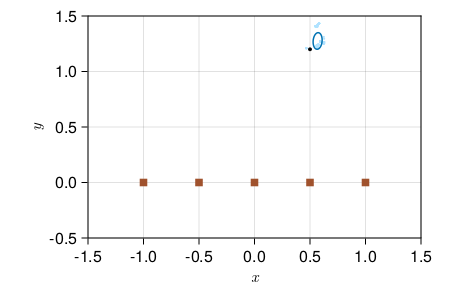

In [101]:
_, best_comp = findmax(wts)

with_theme(xytheme) do
    f = Figure(;resolution=(450,300))
    ax = f[1,1] = Axis(f)

    if plottype == :samples
        show_singularity_samples!(ax,x_decorr_data,obs,nskip=1,markersize=3) #colormap=:Set1_3:RdBu_3,nskip=1)
        #singularity_ellipses!(ax,xm[:,best_comp],Σ[best_comp],obs,color=:red)
        singularity_ellipses!(ax,xm,Σ,obs,fill=false)
        
        #singularity_ellipses!(ax,x_true,Σx,obs_true,color=(:black,0.2),fill=true,strokewidth=0.5)
        
        # Draw some lines to indicate maximum uncertainty direction at true state
        #=
        xid, yid, Γid = get_singularity_ids(obs_true.config)
        F = svd(H,full=true)
        vmax = F.Vt[end,:]
        for j = 1:number_of_singularities(obs_true.config)
            lines!(ax,[real(zv)[j]-vmax[xid[j]],real(zv)[j]+vmax[xid[j]]],[imag(zv)[j]-vmax[yid[j]],imag(zv)[j]+vmax[yid[j]]],color=:black,linewidth=0.5)
        end
        =#
    
    elseif plottype == :heater
        hmin, hmax = -1.5,1.5 #-0.25,0.25
        lev = range(hmin,hmax,length=20)
        plot_expected_sourcefield!(ax,xm,Σh,obs,xlims=(-2,2),ylims=(-1,2.5),colormap=cgrad(:lighttemperaturemap,rev=true),linewidth=2,colorrange=(hmin,hmax),levels=lev)
        
        #comp = 9 # best_comp
        #plot_expected_sourcefield!(ax,xm[:,comp],Σ[comp],obs,ylims=(-1,2.5),colormap=cgrad(:lighttemperaturemap,rev=true),linewidth=2,colorrange=(wmin,wmax),levels=lev)

        Σ_true = state_covariance(δ_true^2,δ_true^2,0.0,0.0,config_true);        
        plot_expected_sourcefield!(ax,x_true,Σ_true,obs_true,ylims=(-1,2),colormap=cgrad(:lighttemperaturemap,rev=true),linestyle=:dot,linewidth=1,colorrange=(hmin,hmax),levels=lev)
        
    end
    
    #lines!(ax,real(zc),imag(zc);marker=:none,color=:gray)
    #lines!(ax,[0.0,real(z0)],[0.0,imag(z0)],marker=:none,color=:gray)

    scatter!(ax,real(zq),imag(zq),marker=:circle,markersize=4,color=:black,strokewidth=1)
  
    plot_sensors!(ax,obs,color=:sienna)
    #ylims!(ax,(-0.5,2))
    #xlims!(ax,(-1.5,1.5))
    ylims!(ax,(-0.5,1.5))
    xlims!(ax,(-1.5,1.5))
    
    fullname = String(plottype)*"-"*filename*".svg" 
    saveplot && save(fullname,f)
    f
end

In [53]:
import CairoMakie.GeometryBasics as GB

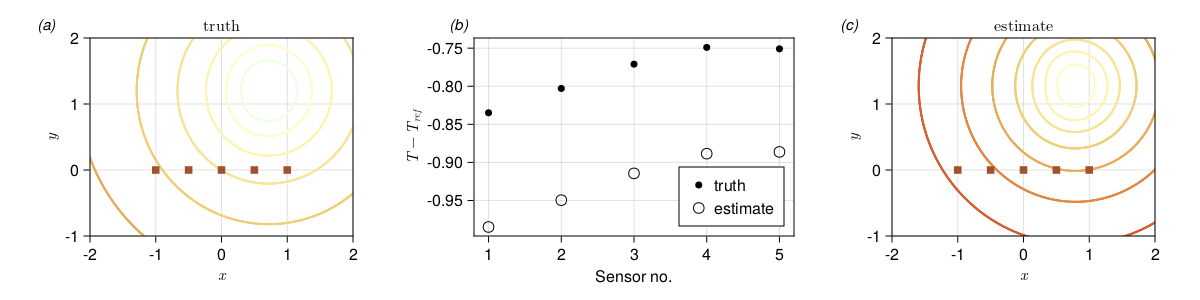

In [61]:
t = 0.0
_, best_comp = findmax(wts)
comp = best_comp
l = range(-12,0.01,length=21)
cl = (-1,0.01)
f = Figure(;resolution=(1200,300))
ga = f[1, 1] = GridLayout()
gb = f[1, 2] = GridLayout()
gc = f[1, 3] = GridLayout()
axleft = Axis(ga[1,1];xlabel=L"x",ylabel=L"y",limits=(-2,2,-1,2),aspect=DataAspect(),title=L"\textrm{truth}")
axright = Axis(gc[1,1];xlabel=L"x",ylabel=L"y",limits=(-2,2,-1,2),aspect=DataAspect(),title=L"\textrm{estimate}")
linkaxes!(axright,axleft)
Tmin, Tmax = -1,-0.2
plot_temperature_field!(axleft,x_true,obs_true,gridConfig,colormap=cgrad(:lighttemperaturemap,rev=true),colorrange=(Tmin,Tmax),levels=range(Tmin,Tmax,length=15),linewidth=2)
plot_sensors!(axleft,obs_true,color=:sienna)
plot_temperature_field!(axright,xm[:,comp],obs,gridConfig,mode=:relative,colormap=cgrad(:lighttemperaturemap,rev=true),colorrange=(Tmin,Tmax),levels=range(Tmin,Tmax,length=15),linewidth=2)
plot_sensors!(axright,obs,color=:sienna)


# Sensor plot
axcenter = Axis(gb[1,1];xticks=1:length(obs.sens),xlabel="Sensor no.",ylabel=L"T-T_{ref}") 
plot_sensor_data!(axcenter,ystar,xm[:,comp],t,obs,gridConfig;sensor_noise=ϵmeas*ones(length(ystar)))
axislegend(axcenter,position=:rb)


for (label, layout) in zip(["(a)", "(b)", "(c)"], [ga, gb, gc])
    Label(layout[1, 1, TopLeft()], label,
        fontsize = 15,
        font = "TeX Heros Italic",
        padding = (0, 5, 5, 0),
        halign = :right)
end
saveplot && save("Temperaturefield-"*filename*".svg",f)

f

In [20]:
x_decorr_data

Ensemble with 501 members of 5-dimensional data
5×501 Matrix{Float64}:
 1.33006     0.582439  0.582439  0.582439  …  0.466235  0.466235  0.466235
 1.53104     1.43315   1.43315   1.43315      1.20993   1.20993   1.20993
 0.623932    0.576778  0.576778  0.576778     0.665111  0.665111  0.665111
 0.724553    0.634965  0.634965  0.634965     0.606888  0.606888  0.606888
 0.00164398  0.413606  0.413606  0.413606     0.31795   0.31795   0.31795

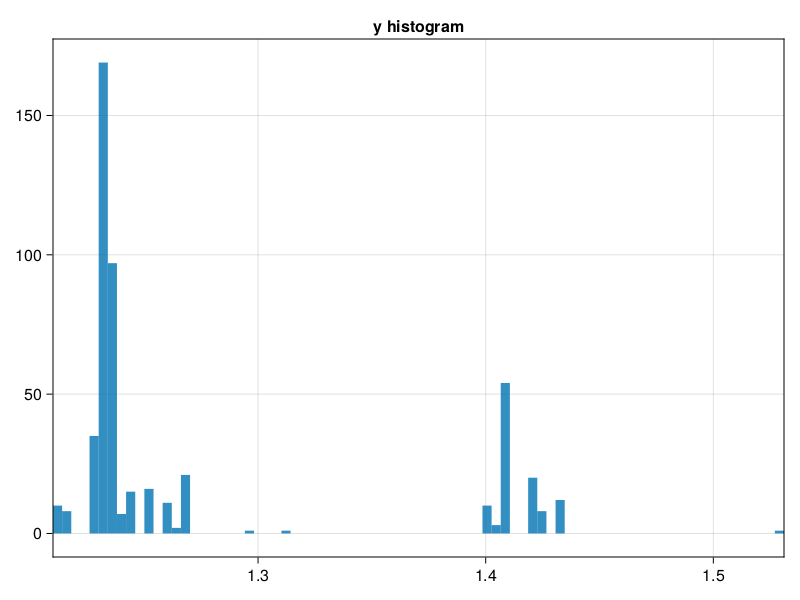

In [33]:
data_histogram(x_decorr_data[2,:];bins=80,xlims = (minimum(x_decorr_data[2,:]),maximum(x_decorr_data[2,:])), title="y histogram")

In [84]:
show_sampling_history(3,x_decorr_data)

UndefVarError: UndefVarError: show_sampling_history not defined

In [15]:
x_samples_variance = Matrix(x_decorr_data .- xm)

5×501 Matrix{Float64}:
  0.761393   0.0137688   0.0137688  …  -0.102435   -0.102435   -0.102435
  0.25602    0.158127    0.158127      -0.0650934  -0.0650934  -0.0650934
 -0.867599  -0.914753   -0.914753      -0.82642    -0.82642    -0.82642
  0.320878   0.231291    0.231291       0.203213    0.203213    0.203213
 -0.284645   0.127316    0.127316       0.0316602   0.0316602   0.0316602

In [16]:
s = svd(x_samples_variance)

SVD{Float64, Float64, Matrix{Float64}, Vector{Float64}}
U factor:
5×5 Matrix{Float64}:
 -0.00731013  -0.876541    0.0591343   0.327147   0.347995
  0.131592    -0.370534   -0.704314   -0.392125  -0.442231
 -0.9555      -0.0258731  -0.132924   -0.219291   0.1435
  0.232348    -0.0828599   0.210754   -0.796929   0.509545
  0.125154     0.294696   -0.662087    0.236703   0.634904
singular values:
5-element Vector{Float64}:
 11.807061803877613
  1.0242963995015457
  0.6633219769848211
  0.3021607236930222
  0.07051356837072693
Vt factor:
5×501 Matrix{Float64}:
  0.0758907   0.0816823   0.0816823  …   0.0705515   0.0705515   0.0705515
 -0.830112   -0.0279585  -0.0279585      0.124751    0.124751    0.124751
  0.355961   -0.0369549  -0.0369549      0.258556    0.258556    0.258556
  0.0524854  -0.036702   -0.036702       0.0621766   0.0621766   0.0621766
  0.142095    0.0323721   0.0323721     -0.0255876  -0.0255876  -0.0255876

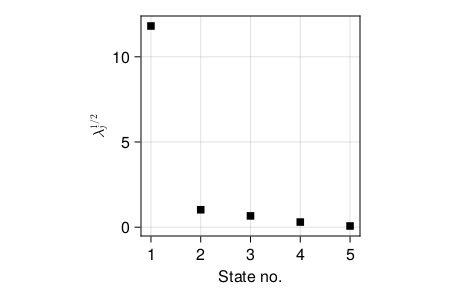

In [44]:
f = Figure(;resolution=(450,300))
ax = f[1,1] = Axis(f;aspect=1,xlabel="State no.",ylabel=L"λ_j^{1/2}")
sample_idx = 1:size(x_decorr_data,1)
scatter!(ax,sample_idx,s.S;marker=:rect,color=:black)
f

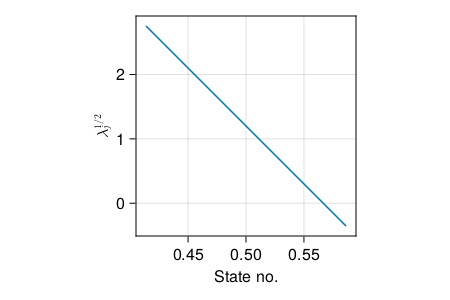

In [56]:
f = Figure(;resolution=(450,300))
ax = f[1,1] = Axis(f;aspect=1,xlabel="State no.",ylabel=L"λ_j^{1/2}")
max_data_dir = s.U[:,1].*s.S[1]
x = [-max_data_dir[1], max_data_dir[1]] .+ x_true[1]
y = [-max_data_dir[2], max_data_dir[2]] .+ x_true[2]
lines!(ax,x,y;marker=:none)
f

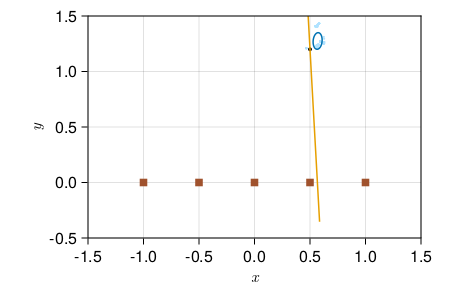

In [57]:
_, best_comp = findmax(wts)

with_theme(xytheme) do
    f = Figure(;resolution=(450,300))
    ax = f[1,1] = Axis(f)

    if plottype == :samples
        show_singularity_samples!(ax,x_decorr_data,obs,nskip=1,markersize=3) #colormap=:Set1_3:RdBu_3,nskip=1)
        #singularity_ellipses!(ax,xm[:,best_comp],Σ[best_comp],obs,color=:red)
        singularity_ellipses!(ax,xm,Σ,obs,fill=false)
        
        #singularity_ellipses!(ax,x_true,Σx,obs_true,color=(:black,0.2),fill=true,strokewidth=0.5)
        
        # Draw some lines to indicate maximum uncertainty direction at true state
        #=
        xid, yid, Γid = get_singularity_ids(obs_true.config)
        F = svd(H,full=true)
        vmax = F.Vt[end,:]
        for j = 1:number_of_singularities(obs_true.config)
            lines!(ax,[real(zv)[j]-vmax[xid[j]],real(zv)[j]+vmax[xid[j]]],[imag(zv)[j]-vmax[yid[j]],imag(zv)[j]+vmax[yid[j]]],color=:black,linewidth=0.5)
        end
        =#
    
    elseif plottype == :heater
        hmin, hmax = -1.5,1.5 #-0.25,0.25
        lev = range(hmin,hmax,length=20)
        plot_expected_sourcefield!(ax,xm,Σh,obs,xlims=(-2,2),ylims=(-1,2.5),colormap=cgrad(:lighttemperaturemap,rev=true),linewidth=2,colorrange=(hmin,hmax),levels=lev)
        
        #comp = 9 # best_comp
        #plot_expected_sourcefield!(ax,xm[:,comp],Σ[comp],obs,ylims=(-1,2.5),colormap=cgrad(:lighttemperaturemap,rev=true),linewidth=2,colorrange=(wmin,wmax),levels=lev)

        Σ_true = state_covariance(δ_true^2,δ_true^2,0.0,0.0,config_true);        
        plot_expected_sourcefield!(ax,x_true,Σ_true,obs_true,ylims=(-1,2),colormap=cgrad(:lighttemperaturemap,rev=true),linestyle=:dot,linewidth=1,colorrange=(hmin,hmax),levels=lev)
        
    end
    
    #lines!(ax,real(zc),imag(zc);marker=:none,color=:gray)
    #lines!(ax,[0.0,real(z0)],[0.0,imag(z0)],marker=:none,color=:gray)

    scatter!(ax,real(zq),imag(zq),marker=:circle,markersize=4,color=:black,strokewidth=1)
  
    plot_sensors!(ax,obs,color=:sienna)

    max_data_dir = s.U[:,1].*s.S[1]
    x_max_unc = [-max_data_dir[1], max_data_dir[1]] .+ x_true[1]
    y_max_unc = [-max_data_dir[2], max_data_dir[2]] .+ x_true[2]
    lines!(ax,x_max_unc,y_max_unc;marker=:none)
    
    #ylims!(ax,(-0.5,2))
    #xlims!(ax,(-1.5,1.5))
    ylims!(ax,(-0.5,1.5))
    xlims!(ax,(-1.5,1.5))
    
    fullname = String(plottype)*"-"*filename*".svg" 
    saveplot && save(fullname,f)
    f
end

In [55]:
s_Σ = svd(Σ)

SVD{Float64, Float64, Matrix{Float64}, Vector{Float64}}
U factor:
5×5 Matrix{Float64}:
 -0.00731013  -0.876541    0.0591343   0.327147   0.347995
  0.131592    -0.370534   -0.704314   -0.392125  -0.442231
 -0.9555      -0.0258731  -0.132924   -0.219291   0.1435
  0.232348    -0.0828599   0.210754   -0.796929   0.509545
  0.125154     0.294696   -0.662087    0.236703   0.634904
singular values:
5-element Vector{Float64}:
 0.27881341688113737
 0.0020983662280646687
 0.0008799920903032533
 0.00018260220588583653
 9.944326648319689e-6
Vt factor:
5×5 Matrix{Float64}:
 -0.00731013   0.131592  -0.9555      0.232348    0.125154
 -0.876541    -0.370534  -0.0258731  -0.0828599   0.294696
  0.0591343   -0.704314  -0.132924    0.210754   -0.662087
  0.327147    -0.392125  -0.219291   -0.796929    0.236703
  0.347995    -0.442231   0.1435      0.509545    0.634904

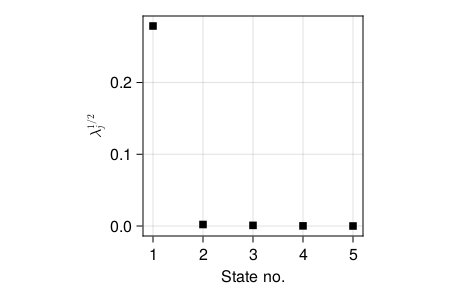

In [62]:
f = Figure(;resolution=(450,300))
ax = f[1,1] = Axis(f;aspect=1,xlabel="State no.",ylabel=L"λ_j^{1/2}")
sample_idx = 1:size(x_decorr_data,1)
scatter!(ax,sample_idx,s_Σ.S;marker=:rect,color=:black)
f

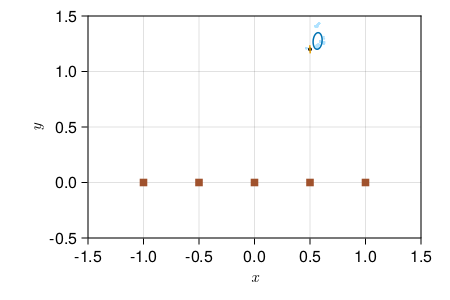

In [59]:
_, best_comp = findmax(wts)

with_theme(xytheme) do
    f = Figure(;resolution=(450,300))
    ax = f[1,1] = Axis(f)

    if plottype == :samples
        show_singularity_samples!(ax,x_decorr_data,obs,nskip=1,markersize=3) #colormap=:Set1_3:RdBu_3,nskip=1)
        #singularity_ellipses!(ax,xm[:,best_comp],Σ[best_comp],obs,color=:red)
        singularity_ellipses!(ax,xm,Σ,obs,fill=false)
        
        #singularity_ellipses!(ax,x_true,Σx,obs_true,color=(:black,0.2),fill=true,strokewidth=0.5)
        
        # Draw some lines to indicate maximum uncertainty direction at true state
        #=
        xid, yid, Γid = get_singularity_ids(obs_true.config)
        F = svd(H,full=true)
        vmax = F.Vt[end,:]
        for j = 1:number_of_singularities(obs_true.config)
            lines!(ax,[real(zv)[j]-vmax[xid[j]],real(zv)[j]+vmax[xid[j]]],[imag(zv)[j]-vmax[yid[j]],imag(zv)[j]+vmax[yid[j]]],color=:black,linewidth=0.5)
        end
        =#
    
    elseif plottype == :heater
        hmin, hmax = -1.5,1.5 #-0.25,0.25
        lev = range(hmin,hmax,length=20)
        plot_expected_sourcefield!(ax,xm,Σh,obs,xlims=(-2,2),ylims=(-1,2.5),colormap=cgrad(:lighttemperaturemap,rev=true),linewidth=2,colorrange=(hmin,hmax),levels=lev)
        
        #comp = 9 # best_comp
        #plot_expected_sourcefield!(ax,xm[:,comp],Σ[comp],obs,ylims=(-1,2.5),colormap=cgrad(:lighttemperaturemap,rev=true),linewidth=2,colorrange=(wmin,wmax),levels=lev)

        Σ_true = state_covariance(δ_true^2,δ_true^2,0.0,0.0,config_true);        
        plot_expected_sourcefield!(ax,x_true,Σ_true,obs_true,ylims=(-1,2),colormap=cgrad(:lighttemperaturemap,rev=true),linestyle=:dot,linewidth=1,colorrange=(hmin,hmax),levels=lev)
        
    end
    
    #lines!(ax,real(zc),imag(zc);marker=:none,color=:gray)
    #lines!(ax,[0.0,real(z0)],[0.0,imag(z0)],marker=:none,color=:gray)

    scatter!(ax,real(zq),imag(zq),marker=:circle,markersize=4,color=:black,strokewidth=1)
  
    plot_sensors!(ax,obs,color=:sienna)

    max_unc_dir = s_Σ.U[:,1].*s_Σ.S[1]
    x_max_unc = [-max_unc_dir[1], max_unc_dir[1]] .+ x_true[1]
    y_max_unc = [-max_unc_dir[2], max_unc_dir[2]] .+ x_true[2]
    lines!(ax,x_max_unc,y_max_unc;marker=:none)
    
    #ylims!(ax,(-0.5,2))
    #xlims!(ax,(-1.5,1.5))
    ylims!(ax,(-0.5,1.5))
    xlims!(ax,(-1.5,1.5))
    
    fullname = String(plottype)*"-"*filename*".svg" 
    saveplot && save(fullname,f)
    f
end

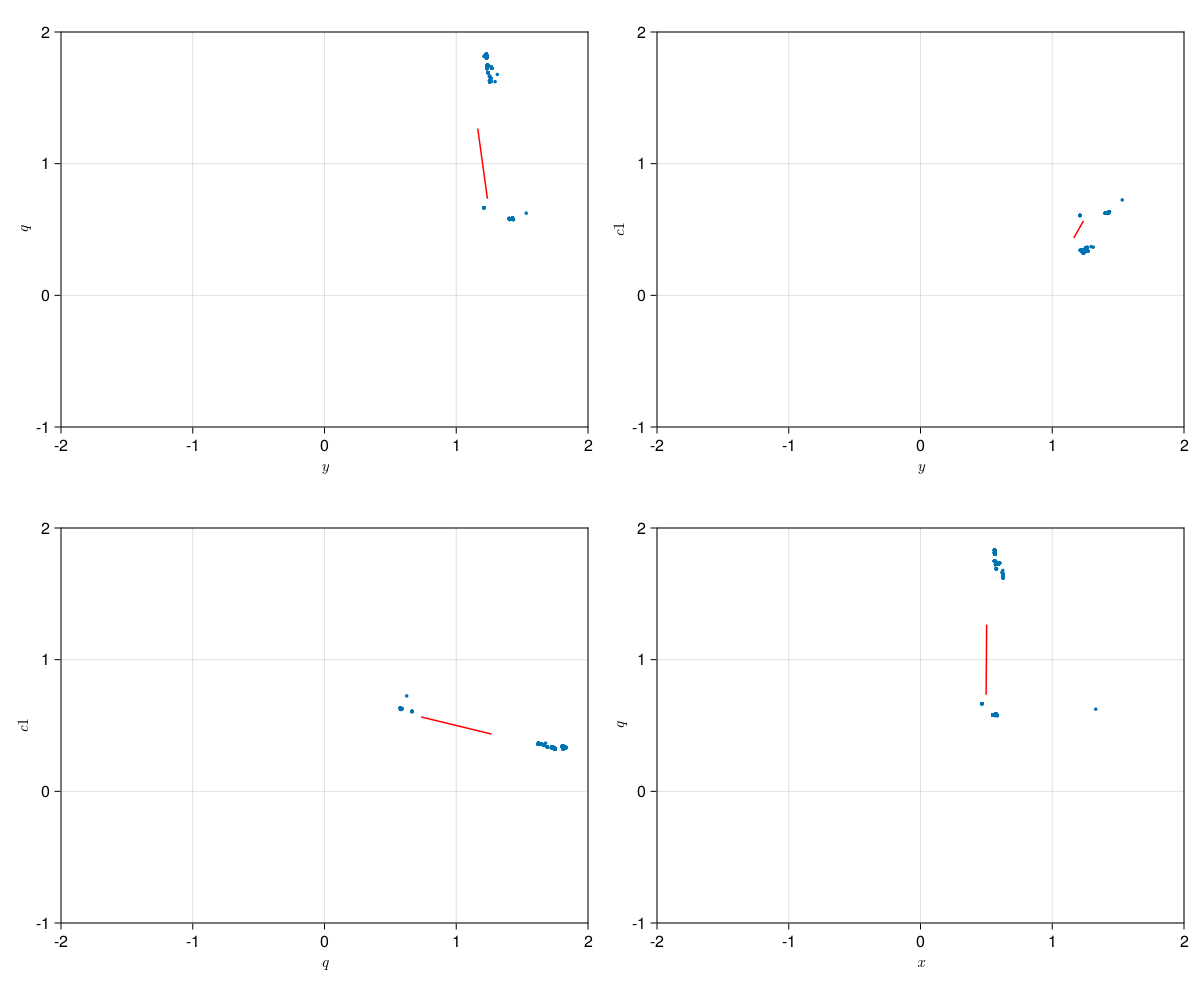

In [71]:
f = Figure(;resolution=(1200,1000))
ga = f[1, 1] = GridLayout()
gb = f[1, 2] = GridLayout()
gc = f[2, 1] = GridLayout()
gd = f[2, 2] = GridLayout()
ax_size = (800, 400)
axleft1 = Axis(ga[1,1]; xlabel=L"y",ylabel=L"q",limits=(-2,2,-1,2),aspect=DataAspect())
axright1 = Axis(gb[1,1];xlabel=L"y",ylabel=L"c1",limits=(-2,2,-1,2),aspect=DataAspect())
axleft2 = Axis(gc[1,1];xlabel=L"q",ylabel=L"c1",limits=(-2,2,-1,2),aspect=DataAspect())
axright2 = Axis(gd[1,1];xlabel=L"x",ylabel=L"q",limits=(-2,2,-1,2),aspect=DataAspect())

xΣ = [-max_unc_dir[1], max_unc_dir[1]] .+ x_true[1]
yΣ = [-max_unc_dir[2], max_unc_dir[2]] .+ x_true[2]
qΣ = [-max_unc_dir[3], max_unc_dir[3]] .+ x_true[3]
c1Σ = [-max_unc_dir[4], max_unc_dir[4]] .+ x_true[4]
scatter!(axleft1,x_decorr_data[2,:],x_decorr_data[3,:];markersize=5,label="sample")
lines!(axleft1,yΣ,qΣ;marker=:none,color=:red)
scatter!(axright1,x_decorr_data[2,:],x_decorr_data[4,:];markersize=5,label="sample")
lines!(axright1,yΣ,c1Σ;marker=:none,color=:red)
scatter!(axleft2,x_decorr_data[3,:],x_decorr_data[4,:];markersize=5,label="sample")
lines!(axleft2,qΣ,c1Σ;marker=:none,color=:red)
scatter!(axright2,x_decorr_data[1,:],x_decorr_data[3,:];markersize=5,label="sample")
lines!(axright2,xΣ,qΣ;marker=:none,color=:red)
f